In [1]:
import keras
import numpy as np
import os
import os.path
import cv2
import matplotlib.pyplot as plt
import glob
import imutils
from imutils import paths

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K

C:\Users\Phil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [1]:
# The code and general problem-solving from this is largely based off the approach detailed in this
# tutorial: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710

# This version of solving the captcha problem uses a Convolutional Neural Network, more akin to
# the original tutorial. As expected, the CNN model results in a much more accurate model
# than the Linear Regression.

# NOTE that this code already assumes that you have extracted the data and parsed it into testing
# and training. The code to do that is in Linear Regression Captcha Cracker.ipynb

In [2]:
def resize_to_fit(image, width, height):
    
    (h, w) = image.shape[:2]
    
    if w > h:
        image = imutils.resize(image, width=width)
        
    else:
        image = imutils.resize(image, height=height)
        
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((width - image.shape[0]) / 2.0)
    
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))
    
    return image


In [3]:
# get the data from the folders
LETTER_IMAGES_FOLDER = "extracted_letter_images"
TEST_IMAGES_FOLDER = "extracted_letter_test_images"

#make the training data and testing data
x_train = []
y_train = []

x_test = []
y_test = []

#get the training data first from the folder
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = resize_to_fit(image, 20, 20)
    
    #might not need to be here...
    image = np.expand_dims(image, axis=2)
    
    label = image_file.split(os.path.sep)[-2]
    
    x_train.append(image)
    y_train.append(label)
    
# get the testing data next, similar process as before
for image_file in paths.list_images(TEST_IMAGES_FOLDER):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = resize_to_fit(image, 20, 20)
    
    image = np.expand_dims(image, axis=2)
    
    label = image_file.split(os.path.sep)[-2]
    
    x_test.append(image)
    y_test.append(label)


# turn the inputs into arrays to make them easier to manipulate
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_train[0].shape)
print(y_train[0])

print('x_train original shape:', x_train.shape )
print('y_train original shape:', y_train.shape )
print('x_test original shape:', x_test.shape )
print('y_test original shape:', y_test.shape )

(20, 20, 1)
2
x_train original shape: (32000, 20, 20, 1)
y_train original shape: (32000,)
x_test original shape: (6744, 20, 20, 1)
y_test original shape: (6744,)


In [4]:
#normalize pixels to be between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test /= 255
x_train /= 255

In [5]:
#convert our labels into a 'one-hot' array
alphabet = "ABCDEFGHJKLMNPQRSTUVWXYZ23456789"
chr_to_idx = dict((c, i)for i,c in enumerate(alphabet))
idx_to_chr = dict((i, c)for i,c in enumerate(alphabet))

y_train_OH = np.zeros((len(y_train),len(alphabet)) )
y_test_OH = np.zeros((len(y_test),len(alphabet)) )

for i in range(len(y_train)):
    y_train_OH[i][chr_to_idx[y_train[i]]] = 1
    
for i in range(len(y_test)):
    y_test_OH[i][chr_to_idx[y_test[i]]] = 1
print(y_train_OH.shape)

(32000, 32)


In [6]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(20,20,1)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='softmax'))


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 18, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [8]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train_OH,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test_OH))

Train on 32000 samples, validate on 6744 samples
Epoch 1/20
32000/32000 [==============================] - 6s 197us/step - loss: 0.6312 - acc: 0.8303 - val_loss: 0.0515 - val_acc: 0.9871
Epoch 2/20
32000/32000 [==============================] - 3s 101us/step - loss: 0.0647 - acc: 0.9849 - val_loss: 0.0373 - val_acc: 0.9895
Epoch 3/20
32000/32000 [==============================] - 3s 103us/step - loss: 0.0366 - acc: 0.9909 - val_loss: 0.0291 - val_acc: 0.9910 0.0368 - acc: 0.990 - ETA: 0s - loss: 0.0369 - acc: 
Epoch 4/20
32000/32000 [==============================] - 3s 102us/step - loss: 0.0291 - acc: 0.9924 - val_loss: 0.0240 - val_acc: 0.9923
Epoch 5/20
32000/32000 [==============================] - 3s 105us/step - loss: 0.0230 - acc: 0.9939 - val_loss: 0.0226 - val_acc: 0.9932
Epoch 6/20
32000/32000 [==============================] - 3s 102us/step - loss: 0.0195 - acc: 0.9939 - val_loss: 0.0181 - val_acc: 0.9941:
Epoch 7/20
32000/32000 [==============================] - 3s 101us/st

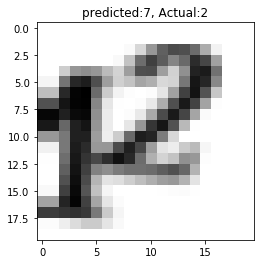

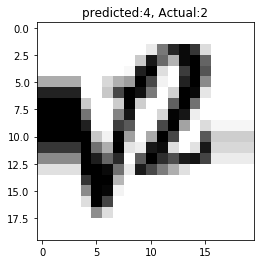

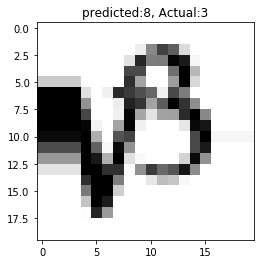

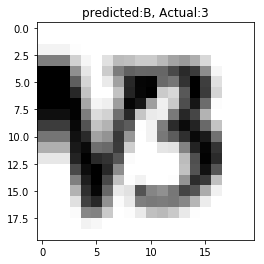

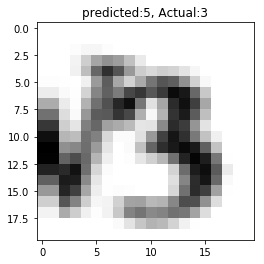

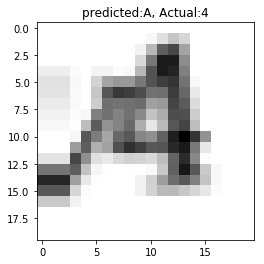

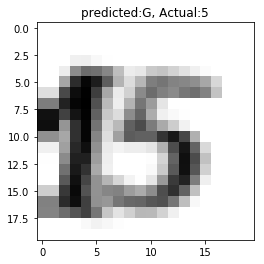

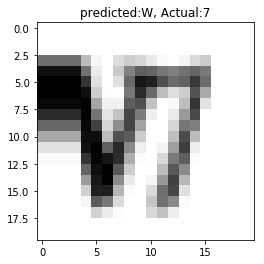

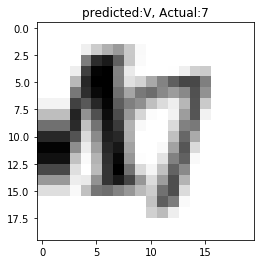

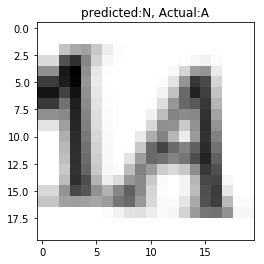

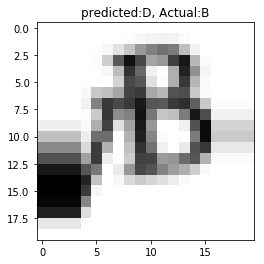

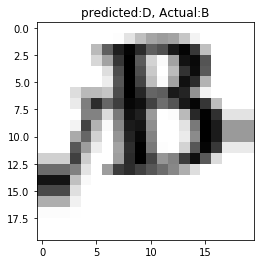

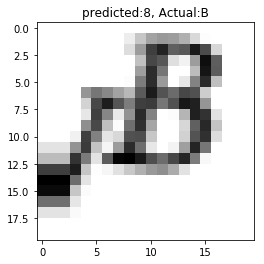

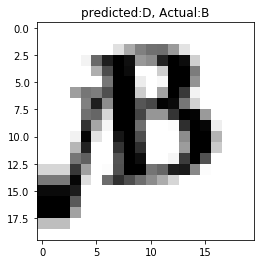

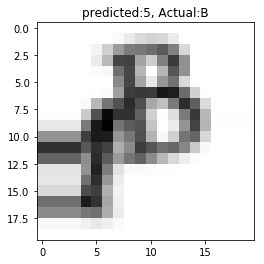

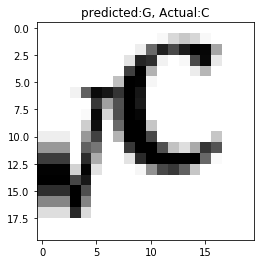

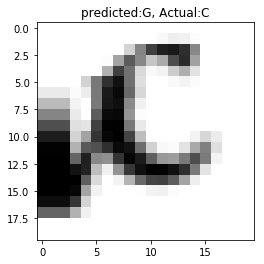

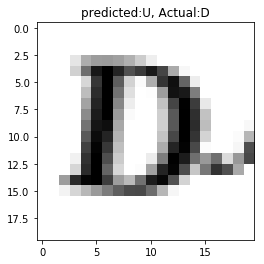

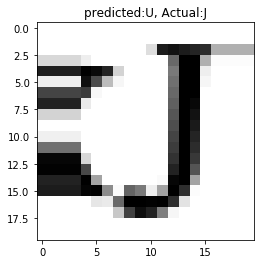

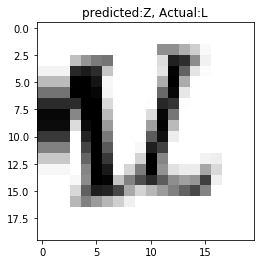

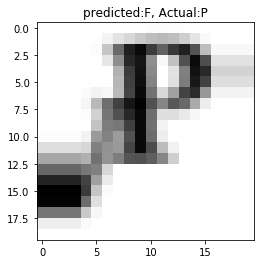

In total, I got 21 wrong out of 6744


In [9]:
# get the predictions from our model
predicted = model.predict_classes(x_test)

count = 0

# plot out the data that the model couldn't guess correctly
for i in range(len(predicted)):
    if idx_to_chr[predicted[i]] != y_test[i]:
        plt.imshow(np.squeeze(x_test[i], axis=2), cmap='gray', interpolation='none')
        plt.title('predicted:'+str(idx_to_chr[predicted[i]])+', Actual:'+str(y_test[i]))
        plt.show()
        count += 1
        
print("In total, I got",count,"wrong out of",len(predicted))

In [10]:
error = count /float(len(predicted)) * 100

print("My percent error was only:",error)

My percent error was only: 0.3113879003558719
